In [2]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

Num GPUs Available:  1
['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


In [3]:
def chooseAction(Q, state, eps):
    if np.random.uniform(low = 0, high = 1) < 1 - eps:
        action = np.argmax(Q[state[0], state[1]])
    else:
        action = np.random.randint(0, env.action_space.n) # Selects int from [0,3)
    return action

def getEpsilon(eps, minEps, currEpisode):
    if eps > minEps:
        eps -= (eps - minEps)/currEpisode
    return eps

In [59]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0")
env.reset()

numStates = (env.observation_space.high - env.observation_space.low)*np.array([10, 100])
numStates = np.round(numStates, 0).astype(int) + 1

Q = np.random.uniform(low = 0, high = 1, size=(numStates[0], numStates[1], env.action_space.n))
V = np.zeros((numStates[0], numStates[1]))
Pi = -1*np.ones((numStates[0], numStates[1]))

numEpisodes = 5000
eta = 0.1
gamma = 0.9
eps = 0.9
rewardList = []
avgRewardList = []
for i in range(numEpisodes):
    # Current state
    totReward = 0
    reward = 0
    sCurr = env.reset()
    sCurrDisc = (sCurr - env.observation_space.low)*np.array([10, 100])
    sCurrDisc = np.round(sCurrDisc, 0).astype(int) + 1
    done = False
    while not done:
        if i >= (numEpisodes - 20):
            env.render()
        
        action = chooseAction(Q, sCurrDisc, eps)
        sNext, reward, done, _ = env.step(action)
        sNextDisc = (sNext - env.observation_space.low)*np.array([10, 100])
        sNextDisc = np.round(sNextDisc, 0).astype(int) + 1
        if done and sNext[0] >= 0.5:
            Q[sCurrDisc[0], sCurrDisc[1], action] = reward
        else:
            Q[sCurrDisc[0], sCurrDisc[1],action] = (1-eta)*Q[sCurrDisc[0], sCurrDisc[1],action] \
            + eta*(reward + gamma*np.max(Q[sNextDisc[0],sNextDisc[1]]))
        sCurrDisc = sNextDisc
        totReward += reward
    
    rewardList.append(totReward)
    eps = getEpsilon(eps, 0.01, i+1)
    if (i+1) % 100 == 0:
        avgReward = np.mean(rewardList)
        avgRewardList.append(avgReward)
        rewardList = []
        print('Episode {} Average Reward {}'.format(i+1, avgReward))
    
env.close()
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        Pi[i,j] = np.argmax(Q[i,j])
        V[i,j] = np.max(Q[i,j])

Episode 100 Average Reward -200.0
Episode 200 Average Reward -200.0
Episode 300 Average Reward -200.0
Episode 400 Average Reward -199.31
Episode 500 Average Reward -193.87
Episode 600 Average Reward -197.78
Episode 700 Average Reward -198.98
Episode 800 Average Reward -198.75
Episode 900 Average Reward -196.29
Episode 1000 Average Reward -187.01
Episode 1100 Average Reward -180.71
Episode 1200 Average Reward -186.19
Episode 1300 Average Reward -188.11
Episode 1400 Average Reward -190.44
Episode 1500 Average Reward -189.16
Episode 1600 Average Reward -188.3
Episode 1700 Average Reward -181.61
Episode 1800 Average Reward -156.22
Episode 1900 Average Reward -188.5
Episode 2000 Average Reward -172.13
Episode 2100 Average Reward -174.27
Episode 2200 Average Reward -186.66
Episode 2300 Average Reward -170.26
Episode 2400 Average Reward -158.05
Episode 2500 Average Reward -155.29
Episode 2600 Average Reward -164.11
Episode 2700 Average Reward -166.41
Episode 2800 Average Reward -172.58
Episod

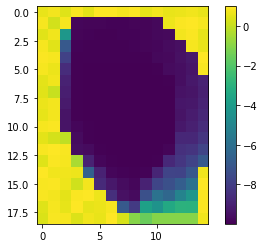

Text(0, 0.5, 'Average reward')

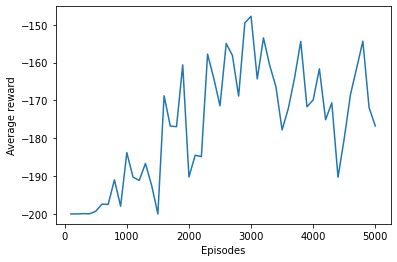

In [57]:
plt.imshow(V)
plt.colorbar()
plt.show()
plt.plot(100*(np.arange(len(avgRewardList)) + 1), avgRewardList)
plt.xlabel('Episodes')
plt.ylabel('Average reward')

In [60]:
# TESTING
eps = 0
sCurr = env.reset()
sCurrDisc = (sCurr - env.observation_space.low)*np.array([10, 100])
sCurrDisc = np.round(sCurrDisc, 0).astype(int) + 1
done = False
env.render()
while not done:
    env.render()
    action = chooseAction(Q, sCurrDisc, eps)
    sNext, reward, done, _ = env.step(action)
    sNextDisc = (sNext - env.observation_space.low)*np.array([10, 100])
    sNextDisc = np.round(sNextDisc, 0).astype(int) + 1
    sCurrDisc = sNextDisc
env.close()